In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
results = pd.read_csv('results_bcast.csv')
print(results.columns)
results.head()

Index(['Size', 'Avg Latency(us)', 'Min Latency(us)', 'Max Latency(us)',
       'Iterations', 'NP_total', 'ALGO', 'ALGO_NAME'],
      dtype='object')


,Size,Avg Latency(us),Min Latency(us),Max Latency(us),Iterations,NP_total,ALGO,ALGO_NAME
0,1,1.70,0.10,3.30,50,2,0,default
1,2,1.74,0.11,3.38,50,2,0,default
2,4,1.71,0.10,3.31,50,2,0,default
3,8,1.71,0.11,3.32,50,2,0,default
4,16,1.72,0.11,3.33,50,2,0,default


# 3D Heatmap

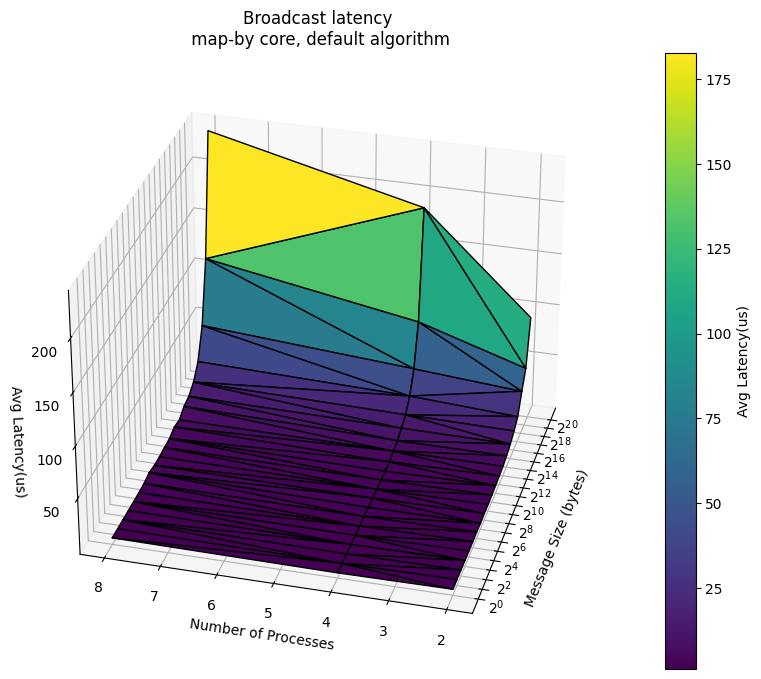

In [300]:
# Filter data for the specific algorithm with index = 0
algorithm_data = results[results['ALGO_NAME'] == 'default']

# Extract relevant columns
x = algorithm_data['Size']
y = algorithm_data['NP_total']
z = algorithm_data['Avg Latency(us)']

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D mesh heatmap
mesh = ax.plot_trisurf(np.log2(x), y, z, cmap='viridis', edgecolor='k')

# Set labels
ax.set_xlabel('Message Size (bytes)')
ax.set_ylabel('Number of Processes')
ax.set_zlabel('Avg Latency(us)')

ax.set_title('Broadcast latency\n map-by core, default algorithm')
fig.colorbar(mesh, ax=ax, label='Avg Latency(us)')
ax.view_init(elev=30, azim=-165)  # Adjust the elevation and azimuth angles as needed

ax.set_xticks(sorted(np.log2(x).unique()))
ax.set_xticklabels([])

tick_labels = ['$2^{%s}$' % int(val) for val in np.log2(x.unique())]
for i, (tick, label) in enumerate(zip(np.log2(x.unique())[::2], tick_labels[::2])):
    ax.text(tick, 1.25, -10, label, ha='center', va='center', rotation=-3)

# Show the plot
plt.show()

# Simple model

In [251]:
import matplotlib.pyplot as plt

# find if cores are mapped first on node1 and then on node2

# Chain latency
# small message so no splitting requires same number of steps as number of nodes
# as cores are mapped first on node1 and then on node2 we can assume
# a single communication between the two nodes with higher latency and a lot
# more communications intranode, so we estimate a mean latency intranode and
# a mean latency inter node and weight the two accordingly to number of processes used
def chain_latency(intra_node_lat, inter_node_lat, num_proc):
    return inter_node_lat + intra_node_lat * (num_proc - 2)

# For binary tree we can estimate the height of the tree assuming it is complete
# using H = log 2(P + 1).
# here is more complex to estimate if the communication is intranode or internode.
# If we assume the cores are assigned on node1 first and then node2 we can assume
def bin_tree_latency(intra_node_lat, inter_node_lat, num_proc):
    height = int(np.log2(num_proc + 1))  # TODO: Maybe is -1 because of root
    return inter_node_lat + intra_node_lat * (height - 1)

intra_node_lat = 2e-6
inter_node_lat = 1e-5
n_proc = [2 ** (k + 1) for k in range(0, np.log2(256).astype(int))]

# Calculate estimated latency for each number of processors
est_lat_chain = np.array([chain_latency(intra_node_lat, inter_node_lat, N) for N in n_proc])
est_lat_chain *= 10**6

est_lat_bin_tree = np.array([bin_tree_latency(intra_node_lat, inter_node_lat, N) for N in n_proc])
est_lat_bin_tree *= 10**6

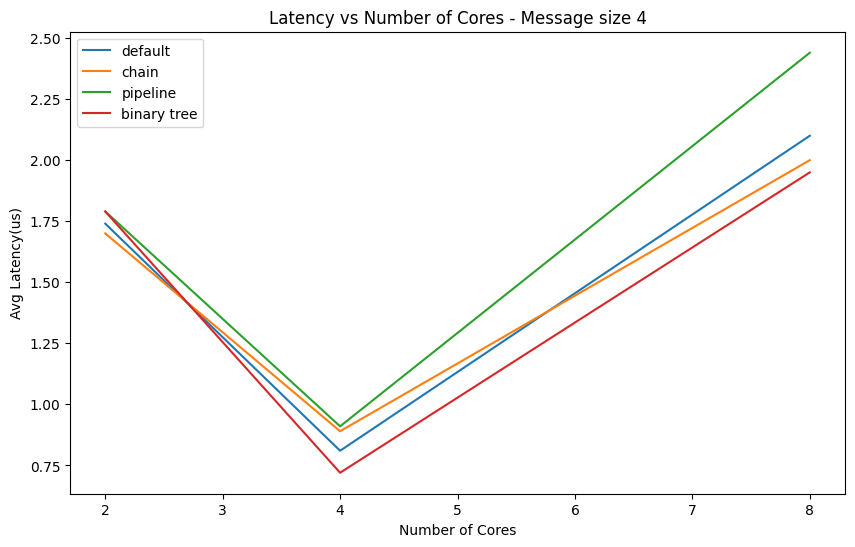

In [301]:
# Extract relevant columns
cores = results['NP_total']
latency = results['Avg Latency(us)']
algo_names = results['ALGO_NAME'].unique()

# Create a line plot with vertical lines
fig, ax = plt.subplots(figsize=(10, 6))

MESSAGE_SIZE = 2

# Plot for each algorithm
for algo_name in algo_names:
    algo_data = results[(results['ALGO_NAME'] == algo_name) & (results['Size'] == MESSAGE_SIZE)]
    ax.plot(algo_data['NP_total'], algo_data['Avg Latency(us)'], label=algo_name)

# ax.plot(n_proc, est_lat_chain, label='Performance model - Chain')
# ax.plot(n_proc, est_lat_bin_tree, label='Performance model - Binary tree')

# Add vertical lines for specific numbers of processors
# vertical_lines = [4, 8, 16, 64, 128, 256]
# for line in vertical_lines:
#     ax.axvline(x=line, color='gray', linestyle='--', linewidth=0.8)

# Set labels and title
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Avg Latency(us)')
ax.set_title('Latency vs Number of Cores - Message size 4')

# ax.set_xticks(n_proc)

ax.legend()
plt.show()